 The goal of this notebook is to explore and cluster the neighborhoods in Toronto.

## Table of Contents

1. [Preparing Foursquare](#Preparing-Foursquare)
2. [Preparing the data for the first city (NewYork)](#Preparing-the-data-for-the-first-city-(NewYork))
3. [Preparing the data for the second city (Toronto)](#Preparing-the-data-for-the-second-city-(Toronto))
5. [Joining two cities](#Joining-two-cities)
6. [Cluster Neighborhoods](#Cluster-Neighborhoods)


In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
# import k-means from clustering stage
from sklearn.cluster import KMeans

import json # library to handle JSON files
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['ggplot'])

## Preparing Foursquare

In [2]:
CLIENT_ID = 'M5BQVZYFBWVLX3SM24AAVCXZ2NRXNANGKH3CRE2J2P4YWW4E' # your Foursquare ID
CLIENT_SECRET = 'SSHT1LSRICY1LZAKLJ23TPMOTALAVXQFRLFFPWLUHNWS4QKN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=30):
    total = len(names)
    cnt = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
        cnt = cnt + 1
        print('{} of {}'.format(cnt, total), end='\r')
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        res = requests.get(url).json()
#         print(res)
        results = res["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Preparing the data for the first city (NewYork)

In [141]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
nyc_data = newyork_data['features']
# define the dataframe columns
column_names = ['District', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_df = pd.DataFrame(columns=column_names)
# loop to fill the dataframe
for data in nyc_data:
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_df = nyc_df.append({'District': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
# delete possible duplicate districts with the same location
nyc_df.drop_duplicates(['Latitude','Longitude'], inplace=True)
nyc_df.head()

,District,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


In [6]:
print(nyc_df.shape)
# due to limitations on foursquare API calls we take only the first 100 rows of the data frame
nyc_df = nyc_df.iloc[:100]
print(nyc_df.shape)

(306, 3)
(100, 3)


#### Here's the map of New York

In [8]:
# create map of New York using latitude and longitude values
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(nyc_df['Latitude'], nyc_df['Longitude'], nyc_df['District']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

In [10]:
# city_1_venues = getNearbyVenues(names=nyc_df['District'],
#                                    latitudes=nyc_df['Latitude'],
#                                    longitudes=nyc_df['Longitude'])
# city_1_venues.to_csv(r'city1_venues.csv')
# city_1_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station


In [12]:
nyc_venues = pd.read_csv('nyc_venues.csv', index_col=0)
nyc_venues.head(2)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy


In [13]:
'we have {} venues overall'.format(nyc_venues.shape[0])

'we have 2184 venues overall'

here's the number of venues in each neighbourhood

Text(0, 0.5, 'Number of Venues')

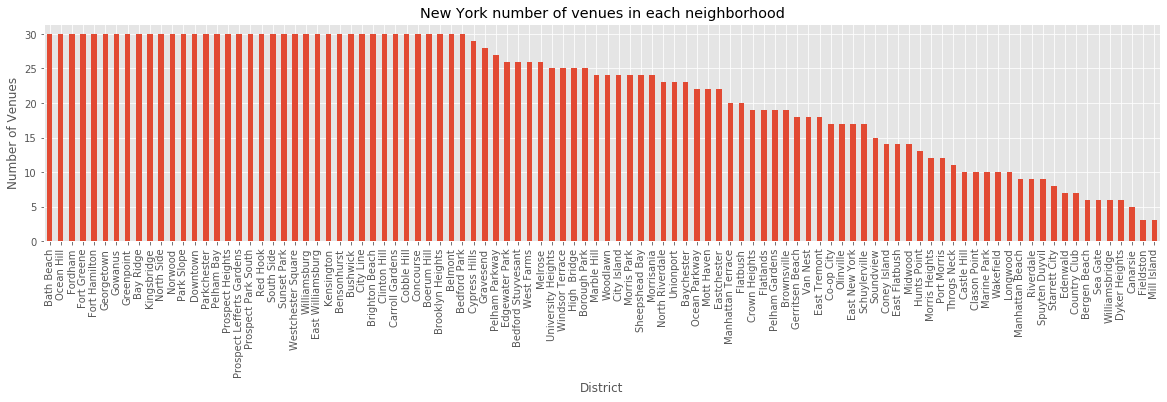

In [14]:
pie_df = nyc_venues.groupby('District').count()
bar_df = pie_df[['Venue']].sort_values(['Venue'], ascending=False)
bar_df.plot(kind='bar', legend=None, figsize=(20, 4))
plt.title('New York number of venues in each neighborhood')
plt.ylabel('Number of Venues')

Text(0, 0.5, '')

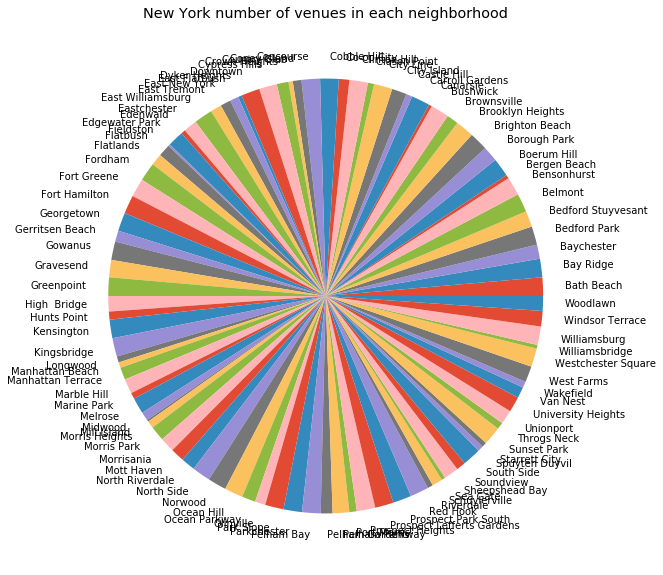

In [15]:
pie_df['Venue'].plot(kind='pie', figsize=(10,10))
plt.title('New York number of venues in each neighborhood')
plt.ylabel('')

In [16]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 258 uniques categories.


#### Analyze Each Neighborhood

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['District'] = nyc_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

#  Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
nyc_categorized = nyc_onehot.groupby('District').mean().reset_index()

#  create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_top10_venues = pd.DataFrame(columns=columns)
nyc_top10_venues['District'] = nyc_categorized['District']

for ind in np.arange(nyc_categorized.shape[0]):
    nyc_top10_venues.iloc[ind, 1:] = return_most_common_venues(nyc_categorized.iloc[ind, :], num_top_venues)
# add a column to indicate the city
nyc_categorized['City'] = 'New York'
nyc_top10_venues['City'] = 'New York'
nyc_top10_venues.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
0,Bath Beach,Italian Restaurant,Fast Food Restaurant,Kids Store,Pharmacy,Bubble Tea Shop,Diner,Donut Shop,Cantonese Restaurant,Chinese Restaurant,German Restaurant,New York
1,Bay Ridge,Italian Restaurant,Spa,Greek Restaurant,Pizza Place,Grocery Store,Optical Shop,Tea Room,Bookstore,Mexican Restaurant,Coffee Shop,New York
2,Baychester,Discount Store,Donut Shop,Sandwich Place,Gym / Fitness Center,Spanish Restaurant,Bus Station,Moving Target,Supermarket,Mexican Restaurant,Men's Store,New York
3,Bedford Park,Diner,Mexican Restaurant,Deli / Bodega,Pizza Place,Supermarket,Sandwich Place,Chinese Restaurant,Bar,Dry Cleaner,Fried Chicken Joint,New York
4,Bedford Stuyvesant,Pizza Place,Coffee Shop,Bar,Café,Park,New American Restaurant,Gourmet Shop,Cocktail Bar,Bus Station,Thrift / Vintage Store,New York


## Preparing the data for the second city (Toronto)

In [150]:
# read toronto districts data from a table in wikipedia
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(link, header=0)
toronto_df = tables[0]

# ignore rows that have Borough not assigned
toronto_df = toronto_df[toronto_df['Borough']!='Not assigned']
toronto_df = toronto_df.reset_index()
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
to_modify = toronto_df[toronto_df['Neighbourhood']=='Not assigned']
to_modify['Neighbourhood'] = to_modify['Borough']
toronto_df.drop(['Borough', 'index'], axis=1, inplace=True)
toronto_df.rename(columns={'Neighbourhood':'District'}, inplace=True)
toronto_df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Postcode,District
0,M3A,Parkwoods
1,M4A,Victoria Village
2,M5A,Harbourfront
3,M5A,Regent Park
4,M6A,Lawrence Heights


In [154]:
## Getting latitude and longtitude from a csv file
coord_toronto_df = pd.read_csv('Geospatial_Coordinates.csv')
coord_toronto_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)
toronto_df = toronto_df.merge(coord_toronto_df)
toronto_df.shape

(103, 4)

In [155]:
# delete possible duplicate districts with the same location
toronto_df.drop_duplicates(['Latitude','Longitude'], inplace=True)
toronto_df = toronto_df.iloc[:100]
toronto_df.head()

,Postcode,District,Latitude,Longitude
0,M3A,Parkwoods,43.753259,-79.329656
1,M4A,Victoria Village,43.725882,-79.315572
2,M5A,Harbourfront,43.654260,-79.360636
3,M6A,Lawrence Heights,43.718518,-79.464763
4,M7A,Not assigned,43.662301,-79.389494


In [189]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['District']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [159]:
# toronto_venues = getNearbyVenues(names=toronto_df['District'],
#                                    latitudes=toronto_df['Latitude'],
#                                    longitudes=toronto_df['Longitude'])
# toronto_venues.to_csv(r'toronto_venues.csv')

In [160]:
toronto_venues = pd.read_csv('toronto_venues.csv', index_col=0)
toronto_venues = toronto_venues.merge(toronto_df)
toronto_venues.drop(['Latitude','Longitude'], axis=1, inplace=True)
cols = toronto_venues.columns.tolist()
toronto_venues = toronto_venues[cols[-1:]+cols[:-1]]
toronto_venues.head()

,Postcode,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,M3A,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Text(0, 0.5, 'Number of Venues')

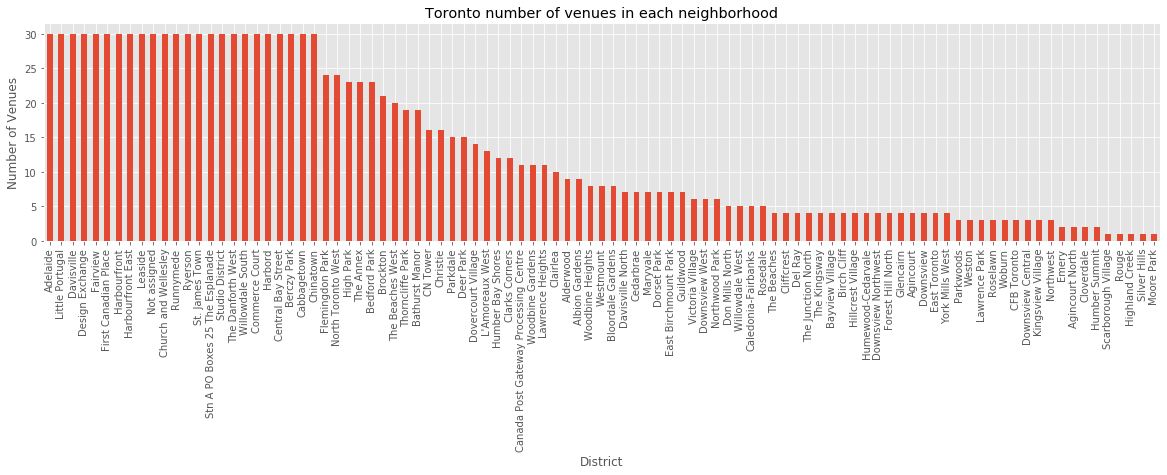

In [161]:
pie_tor_df = toronto_venues.groupby('District').count()
bar_tor_df = pie_tor_df[['Venue']].sort_values(['Venue'], ascending=False)
bar_tor_df.plot(kind='bar', legend=None, figsize=(20, 4))
plt.title('Toronto number of venues in each neighborhood')
plt.ylabel('Number of Venues')

Text(0, 0.5, '')

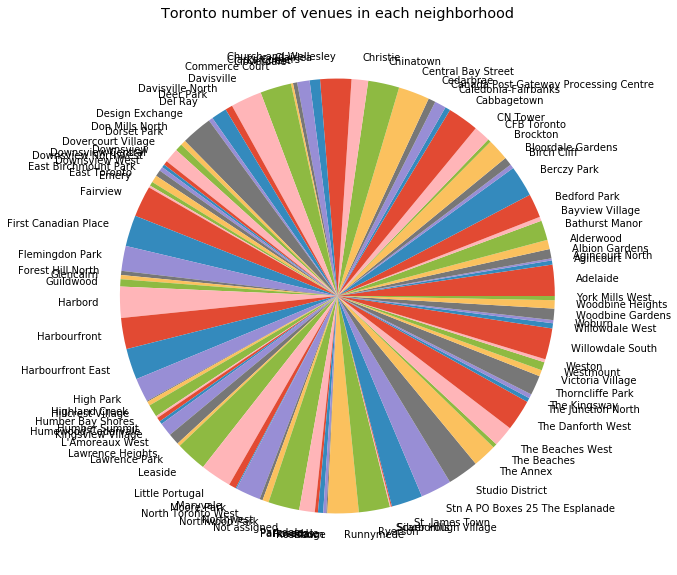

In [162]:
pie_tor_df['Venue'].plot(kind='pie', figsize=(10,10))
plt.title('Toronto number of venues in each neighborhood')
plt.ylabel('')

In [163]:
## Analyze Each Neighborhood
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['District'] = toronto_venues['District'] 
# toronto_onehot['Postcode'] = toronto_venues['Postcode'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#  Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_categorized = toronto_onehot.groupby('District').mean().reset_index()

#  create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tor_top10_venues = pd.DataFrame(columns=columns)
tor_top10_venues['District'] = toronto_categorized['District']

for ind in np.arange(toronto_categorized.shape[0]):
    tor_top10_venues.iloc[ind, 1:] = return_most_common_venues(toronto_categorized.iloc[ind, :], num_top_venues)
# add a column to indicate the city
toronto_categorized['City'] = 'Toronto'
tor_top10_venues['City'] = 'Toronto'

# toronto_categorized = toronto_categorized.merge(toronto_df)

tor_top10_venues.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
0,Adelaide,Steakhouse,Café,Hotel,Coffee Shop,Asian Restaurant,Smoke Shop,Monument / Landmark,Seafood Restaurant,Neighborhood,Speakeasy,Toronto
1,Agincourt,Breakfast Spot,Lounge,Skating Rink,Sandwich Place,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Toronto
2,Agincourt North,Playground,Park,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Toronto
3,Albion Gardens,Grocery Store,Pizza Place,Fried Chicken Joint,Coffee Shop,Sandwich Place,Fast Food Restaurant,Beer Store,Pharmacy,Gay Bar,Dance Studio,Toronto
4,Alderwood,Pizza Place,Pharmacy,Coffee Shop,Gym,Skating Rink,Sandwich Place,Pub,Pool,Diner,Dessert Shop,Toronto


## Joining two cities

#### Now we need to merge these Tehran and Toronto dataframes

In [164]:
toronto_categorized.head(2)

,District,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,City
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Toronto
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Toronto


In [165]:
nyc_categorized.head(2)

,District,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waste Facility,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,City
0,Bath Beach,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,New York
1,Bay Ridge,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,New York


In [195]:
merged_categorized_df = toronto_categorized.append(nyc_categorized, ignore_index=True, sort=False)
merged_top10_venues_df = tor_top10_venues.append(nyc_top10_venues, ignore_index=True, sort=False)
merged_top10_venues_df.fillna(0, inplace=True)
merged_categorized_df.fillna(0, inplace=True)
print('Toronto dataframe shape ', tor_top10_venues.shape)
print('NewYork dataframe shape ', nyc_top10_venues.shape)
print('merged dataframe shape ', merged_top10_venues_df.shape)

Toronto dataframe shape  (97, 12)
NewYork dataframe shape  (100, 12)
merged dataframe shape  (197, 12)


In [33]:
merged_top10_venues_df.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
0,Adelaide,Steakhouse,Asian Restaurant,Café,Hotel,Coffee Shop,Speakeasy,Smoke Shop,Seafood Restaurant,Lounge,Greek Restaurant,Toronto
1,Bathurst Manor,Coffee Shop,Pizza Place,Bank,Bridal Shop,Sandwich Place,Diner,Fast Food Restaurant,Restaurant,Middle Eastern Restaurant,Deli / Bodega,Toronto
2,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Fast Food Restaurant,Farmers Market,Event Space,Empanada Restaurant,Electronics Store,Dog Run,Toronto
3,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Seafood Restaurant,Farmers Market,Café,Comfort Food Restaurant,Clothing Store,Steakhouse,Concert Hall,Toronto
4,Bloordale Gardens,Pharmacy,Pizza Place,Convenience Store,Shopping Plaza,Coffee Shop,Beer Store,Café,Liquor Store,Dim Sum Restaurant,Empanada Restaurant,Toronto


## Cluster Neighborhoods

In [196]:
seed = 10
# set number of clusters
kclusters = 10

clustering_df = merged_categorized_df.drop(['District','City'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_df)

# add clustering labels
merged_top10_venues_df.insert(0, 'Cluster Labels', kmeans.labels_)
clustered_df = merged_top10_venues_df
clustered_df.head()

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
0,4,Adelaide,Steakhouse,Café,Hotel,Coffee Shop,Asian Restaurant,Smoke Shop,Monument / Landmark,Seafood Restaurant,Neighborhood,Speakeasy,Toronto
1,4,Agincourt,Breakfast Spot,Lounge,Skating Rink,Sandwich Place,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Toronto
2,2,Agincourt North,Playground,Park,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Toronto
3,9,Albion Gardens,Grocery Store,Pizza Place,Fried Chicken Joint,Coffee Shop,Sandwich Place,Fast Food Restaurant,Beer Store,Pharmacy,Gay Bar,Dance Studio,Toronto
4,9,Alderwood,Pizza Place,Pharmacy,Coffee Shop,Gym,Skating Rink,Sandwich Place,Pub,Pool,Diner,Dessert Shop,Toronto


In [197]:
# clustered_df = clustered_df.merge(toronto_df.drop(['Postcode'], axis=1), how='left', on='District')
clustered_df.set_index('District', inplace=True)
clustered_df['Latitude'] = np.nan
clustered_df['Longitude'] = np.nan
clustered_df.update(toronto_df.set_index('District'))
clustered_df.update(nyc_df.set_index('District'))
clustered_df.head()

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
District,,,,,,,,,,,,,,
Adelaide,4,Steakhouse,Café,Hotel,Coffee Shop,Asian Restaurant,Smoke Shop,Monument / Landmark,Seafood Restaurant,Neighborhood,Speakeasy,Toronto,43.650571,-79.384568
Agincourt,4,Breakfast Spot,Lounge,Skating Rink,Sandwich Place,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Toronto,43.794200,-79.262029
Agincourt North,2,Playground,Park,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Toronto,43.815252,-79.284577
Albion Gardens,9,Grocery Store,Pizza Place,Fried Chicken Joint,Coffee Shop,Sandwich Place,Fast Food Restaurant,Beer Store,Pharmacy,Gay Bar,Dance Studio,Toronto,43.739416,-79.588437
Alderwood,9,Pizza Place,Pharmacy,Coffee Shop,Gym,Skating Rink,Sandwich Place,Pub,Pool,Diner,Dessert Shop,Toronto,43.602414,-79.543484


Text(0.5, 1.0, 'number of districts in each cluster')

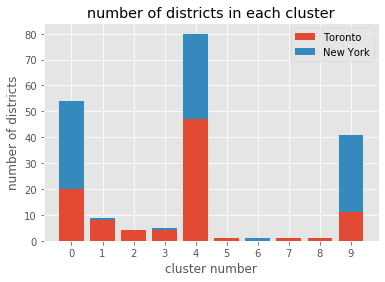

In [201]:
# get number of records in each cluster
cluster_len_tor = []
cluster_len_nyc = []
for i in range(kclusters):
    cluster_len_nyc.append(len(clustered_df.loc[(clustered_df['Cluster Labels'] == i)
                                                    & (clustered_df['City'] == 'New York')]))
    cluster_len_tor.append(len(clustered_df.loc[(clustered_df['Cluster Labels'] == i)
                                                    & (clustered_df['City'] == 'Toronto')]))

plt.bar(np.arange(kclusters), cluster_len_tor, label='Toronto', align='center')
plt.bar(np.arange(kclusters), cluster_len_nyc, label='New York', align='center', bottom=cluster_len_tor)
plt.xticks(np.arange(kclusters))
plt.legend()
plt.xlabel('cluster number')
plt.ylabel('number of districts')
plt.title('number of districts in each cluster')

In [202]:
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
tor_mask = clustered_df['City'] == 'Toronto'
nyc_mask = clustered_df['City'] == 'New York'
markers_colors = []

for lat, lon, poi, cluster in zip(clustered_df[tor_mask]['Latitude'], clustered_df[tor_mask]['Longitude']
                                  , clustered_df[tor_mask].index, clustered_df[tor_mask]['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
for lat, lon, poi, cluster in zip(clustered_df[nyc_mask]['Latitude'], clustered_df[nyc_mask]['Longitude']
                                  , clustered_df[nyc_mask].index, clustered_df[nyc_mask]['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_nyc)

    

display(map_nyc)
display(map_toronto)

In [204]:
clustered_df.loc[(clustered_df['Cluster Labels'] == 3
                 )]

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Latitude,Longitude
District,,,,,,,,,,,,,,
Cliffcrest,3,Motel,American Restaurant,Movie Theater,Yoga Studio,Dim Sum Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Toronto,43.716316,-79.239476
Del Ray,3,Bar,Discount Store,Sandwich Place,Restaurant,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Toronto,43.691116,-79.476013
Highland Creek,3,Bar,Yoga Studio,Field,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Toronto,43.784535,-79.160497
Northwood Park,3,Caribbean Restaurant,Massage Studio,Metro Station,Coffee Shop,Miscellaneous Shop,Bar,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Toronto,43.767980,-79.487262
Williamsbridge,3,Bakery,Nightclub,Caribbean Restaurant,Metro Station,Soup Place,Bar,Yoga Studio,Flea Market,Fish & Chips Shop,Fish Market,New York,40.881039,-73.857446
